Libraries import section

In [ ]:
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings


from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

ML models - Random Forest and LGBM Regressor

In this particular notebook I wanted to showcase how the results may look if I use some of the most known ML algorithms for regression tasks. Having a small amount of variables available in our dataset may not lead to the best results, but I wanted to try to see how good we can do in this situation

In [130]:
ml_model_df = pd.read_csv('ml_model_df.csv')
ml_model_df.set_index('Period',inplace=True)

a) Random Forest Regressor

In this subsection I will build a Random Forest Regressor model in order to assess its performance on our time series data. Also, I will use TimeSeriesSplit method to perform cross validation inside the data to maintain the temporal structure. Also I will use the GridSearchCV method to perform a simple hyperparameter tuning for this task, but maybe optuna or other advanced hyperparam tool would be better.

In [138]:
X = ml_model_df.drop('unemp', axis = 1)
y = ml_model_df['unemp']

tscv = TimeSeriesSplit(n_splits=5, test_size=18)

fold_metrics = []

folds = []

mae_scores = []
mse_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    val_pred = rf_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, val_pred)
    mse = mean_squared_error(y_val, val_pred)
    rmse = np.sqrt(mse)

    fold_metrics.append({
        'Fold': fold + 1,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })
    


fold_metrics_df = pd.DataFrame(fold_metrics)

In [139]:
fold_metrics_df

,Fold,MAE,MSE,RMSE
0,1,1.216944,1.765536,1.328735
1,2,0.699667,0.616897,0.785428
2,3,1.689222,7.263590,2.695105
3,4,1.247056,1.883796,1.372514
4,5,1.135222,2.444075,1.563354


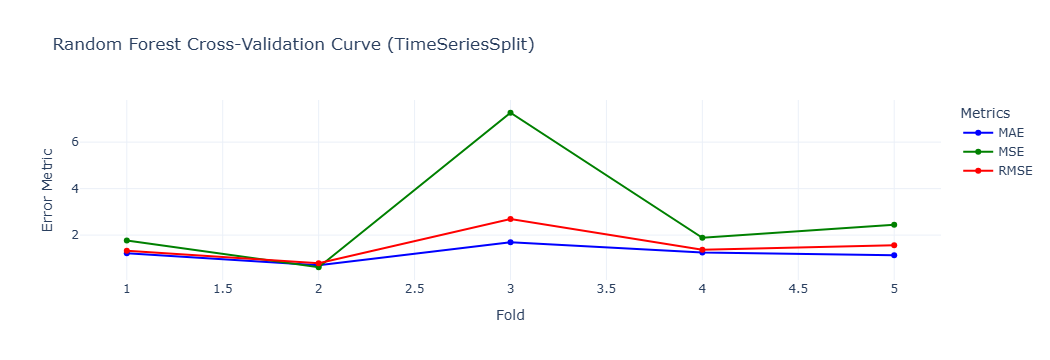

In [140]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=fold_metrics_df['Fold'], y=fold_metrics_df['MAE'], 
                         mode='lines+markers', name='MAE', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=fold_metrics_df['Fold'], y=fold_metrics_df['MSE'], 
                         mode='lines+markers', name='MSE', line=dict(color='green')))
fig.add_trace(go.Scatter(x=fold_metrics_df['Fold'], y=fold_metrics_df['RMSE'], 
                         mode='lines+markers', name='RMSE', line=dict(color='red')))

fig.update_layout(
    title='Random Forest Cross-Validation Curve (TimeSeriesSplit)',
    xaxis_title='Fold',
    yaxis_title='Error Metric',
    legend_title='Metrics',
    template='plotly_white'
)

fig.show()

The results show relatively stable performance across folds with MAE ranging from 0.6997 to 1.6892 and RMSE from 0.7854 to 2.6951. There is a significant performance drop in Fold 3 where MSE (7.2636) and RMSE (2.6951) spike sharply. The model may struggle to generalize during this period, possibly due to outliers, seasonal effects, or an economic shift. Overall, despite the third fold anomaly, the model maintains a consistent error range in other folds, suggesting good generalization on most time slices.

Now I'll train the RF model on the entire data available, then I will forecast for the period up until 2013q4.

In [141]:
X_future = pd.read_csv('X_future_ml.csv', index_col=0)

In [142]:
X_full = ml_model_df.drop(columns=['unemp'])
y_full = ml_model_df['unemp']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_full, y_full)
X_future = X_future[list(X_full)]

unemployment_forecast = rf_model.predict(X_future)

forecast_df = pd.DataFrame({
    'Quarter': X_future.index,
    'Predicted unemployment rate': unemployment_forecast
})

Feature importance plot

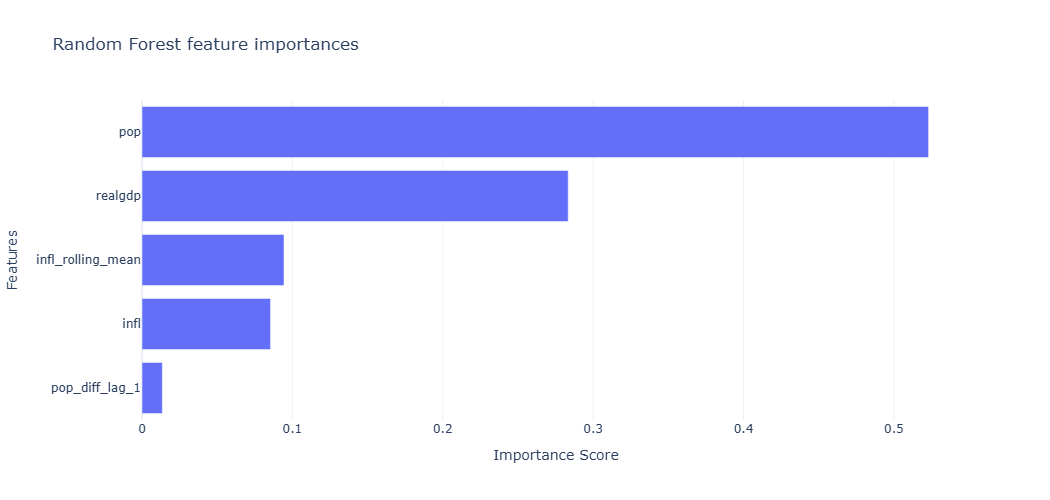

In [143]:
rf_importances = rf_model.feature_importances_
feature_names = X_full.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=True)

fig = px.bar(
    importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Random Forest feature importances',
    labels={'Importance': 'feature importance Score', 'Feature': 'Feature'},
    template='plotly_white'
)

fig.update_layout(
    width=700,
    height=500,
    yaxis_title="Features",
    xaxis_title="Importance Score"
)

fig.show()

Model trained on the full dataset and predictions on future dataset

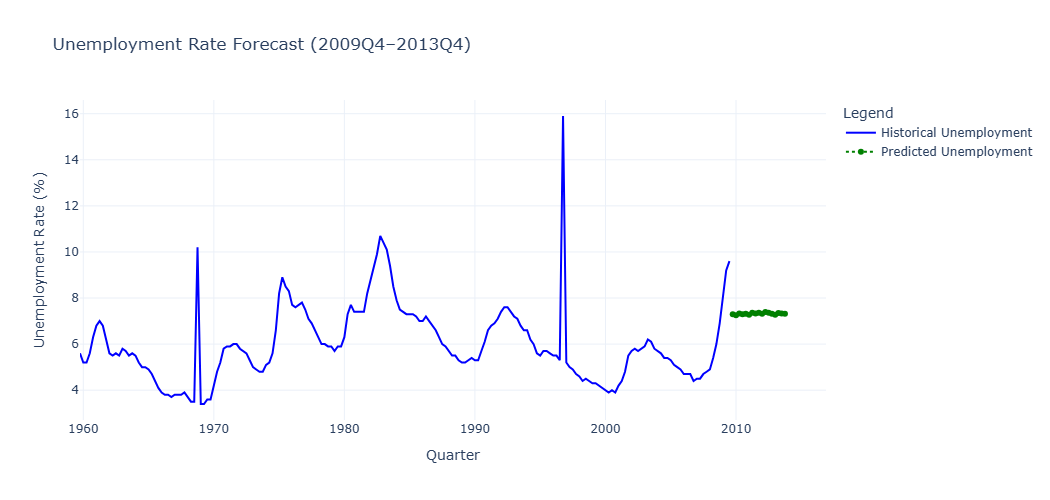

In [144]:
predictions = rf_model.predict(X_future)

np.random.seed(42)
pred_samples = np.array([
    rf_model.predict(X_future) + np.random.normal(0, 0.2, len(X_future))
    for _ in range(100)
])

lower_bound = np.percentile(pred_samples, 2.5, axis=0)
upper_bound = np.percentile(pred_samples, 97.5, axis=0)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ml_model_df.index,
    y=ml_model_df['unemp'],
    mode='lines',
    name='Historical Unemployment',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=X_future.index,
    y=predictions,
    mode='lines+markers',
    name='Predicted Unemployment',
    line=dict(color='green', width=2, dash='dot')
))


fig.update_layout(
    title='Unemployment Rate Forecast (2009Q4–2013Q4)',
    xaxis_title='Quarter',
    yaxis_title='Unemployment Rate (%)',
    legend_title='Legend',
    template='plotly_white',
    showlegend=True,
    width=900,
    height=500
)

fig.show()

b) Light Gradient Boosting Machine regressor (LGBM regressor)

In [164]:
tscv = TimeSeriesSplit(n_splits=5, test_size=18)

lgb_fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full)):
    X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

    lgb_model = lgb.LGBMRegressor(n_estimators=100, num_leaves=2, random_state=42, verbose=-1)
    lgb_model.fit(X_train, y_train)

    val_pred = lgb_model.predict(X_val)

    mae = mean_absolute_error(y_val, val_pred)
    mse = mean_squared_error(y_val, val_pred)
    rmse = np.sqrt(mse)

    lgb_fold_metrics.append({
        'Fold': fold + 1,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

lgb_fold_metrics_df = pd.DataFrame(lgb_fold_metrics)

In [165]:
lgb_fold_metrics_df

,Fold,MAE,MSE,RMSE
0,1,2.073573,4.575814,2.139115
1,2,0.716459,0.626732,0.791664
2,3,2.340783,8.670490,2.944570
3,4,0.456226,0.403577,0.635277
4,5,1.064992,2.804299,1.674604


Cross validation plot for the LGBM model

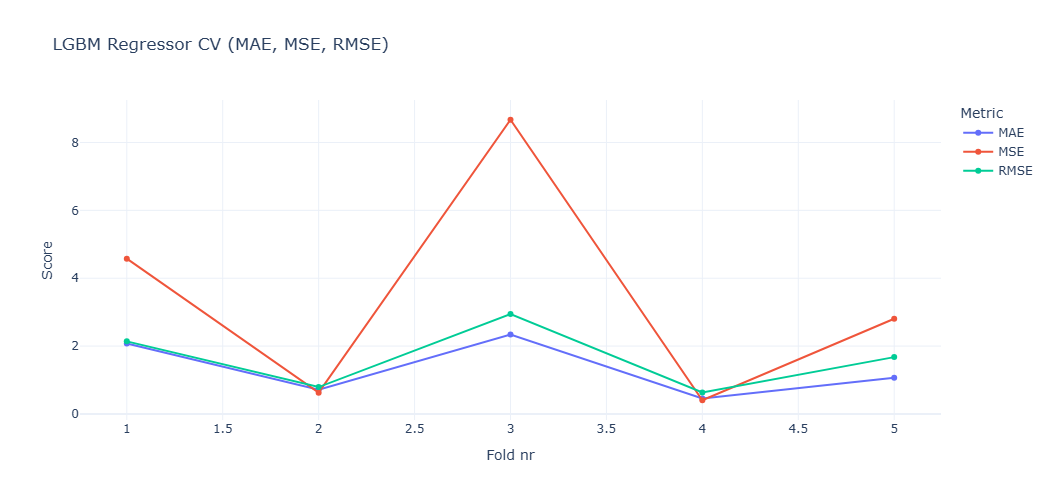

In [166]:
cv_curve_df = pd.DataFrame(lgb_fold_metrics)
cv_curve_long = cv_curve_df.melt(id_vars=['Fold'], value_vars=['MAE', 'MSE', 'RMSE'],
                                 var_name='Metric', value_name='Score')

fig = px.line(
    cv_curve_long,
    x='Fold',
    y='Score',
    color='Metric',
    markers=True,
    title='LGBM Regressor CV (MAE, MSE, RMSE)',
    labels={'Score': 'Error metric', 'Fold': 'CV Fold'},
    template='plotly_white'
)

fig.update_layout(
    width=800,
    height=500,
    xaxis_title='Fold nr',
    yaxis_title='Score',
    legend_title_text='Metric'
)

fig.show()

Feature importance plot for the LGBM model

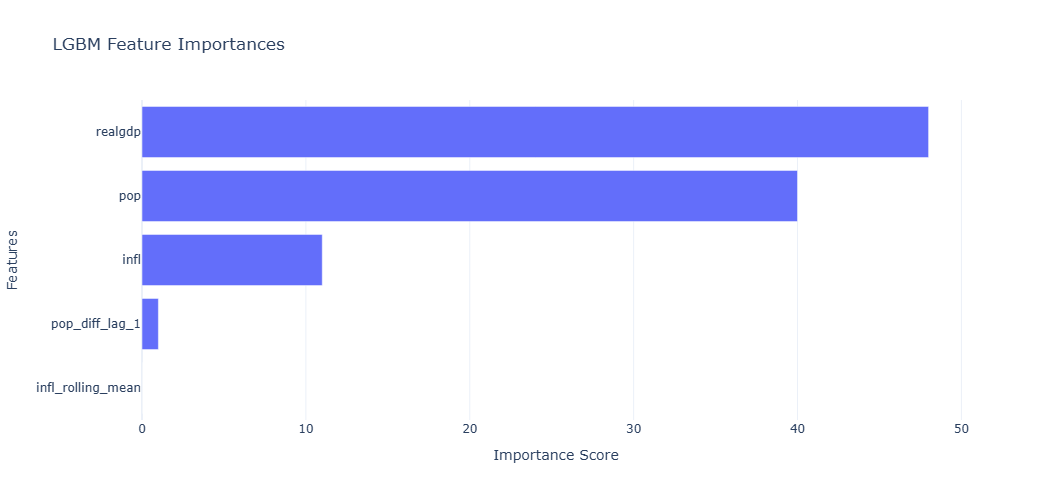

In [167]:
lgb_importances = lgb_model.feature_importances_
feature_names = X_full.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_importances
}).sort_values(by='Importance', ascending=True)

fig = px.bar(
    importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='LGBM Feature Importances',
    labels={'Importance': 'Importance Score'},
    template='plotly_white'
)

fig.update_layout(
    width=700,
    height=500,
    yaxis_title="Features",
    xaxis_title="Importance Score"
)

fig.show()

In [169]:

lgbm_model = lgb.LGBMRegressor(n_estimators=100, num_leaves=2, random_state=42)
lgbm_model.fit(X_full, y_full)
X_future = X_future[list(X_full)]

unemployment_forecast = lgbm_model.predict(X_future)

forecast_df = pd.DataFrame({
    'Quarter': X_future.index,
    'Predicted unemployment rate': unemployment_forecast
})

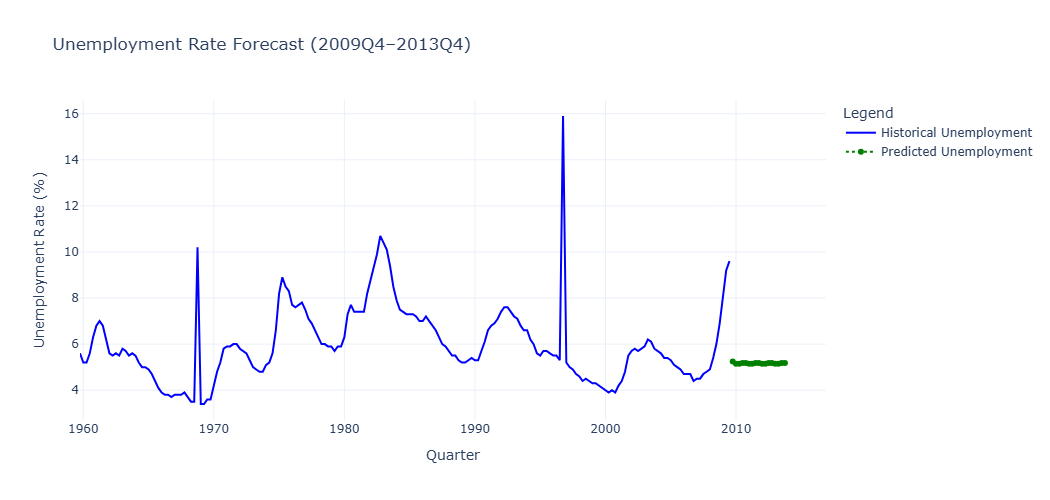

In [170]:
predictions = lgb_model.predict(X_future)

np.random.seed(42)
pred_samples = np.array([
    rf_model.predict(X_future) + np.random.normal(0, 0.2, len(X_future))
    for _ in range(100)
])

lower_bound = np.percentile(pred_samples, 2.5, axis=0)
upper_bound = np.percentile(pred_samples, 97.5, axis=0)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ml_model_df.index,
    y=ml_model_df['unemp'],
    mode='lines',
    name='Historical Unemployment',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=X_future.index,
    y=predictions,
    mode='lines+markers',
    name='Predicted Unemployment',
    line=dict(color='green', width=2, dash='dot')
))


fig.update_layout(
    title='Unemployment Rate Forecast (2009Q4–2013Q4)',
    xaxis_title='Quarter',
    yaxis_title='Unemployment Rate (%)',
    legend_title='Legend',
    template='plotly_white',
    showlegend=True,
    width=900,
    height=500
)

fig.show()